In [ ]:
#import os #works with os related functions like getdir,open,close on os files and folders and much more
import requests #for working with server to pull data
import json #for working with key value pair here
#import sys #enables os functions
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


url = "https://developers.zomato.com/api/v2.1/"
apikey = "c3c70a281939e72f0e1138e5f41a8ab9"
headers = {'Accept': 'application/json','user-key': apikey,}  #additional information to access url

#To get entity id and type 
def get_location_details(query):
  params = {'query' : query} #to get customised search url according to user input 
  response = json.loads(requests.get(url + "locations?",headers=headers,params=params).content.decode("utf-8"))
  for i in response['location_suggestions'] :
    country_name = i['country_name'] 
    if country_name in ("Ireland","India") :
       latitude,longitude,loc_id,loc_type = i['latitude'],i['longitude'],i['entity_id'],i['entity_type']
       return latitude,longitude,loc_id,loc_type
    else :
      return None

#To get cuisine 
def get_cuisines(lat,long):
  #to get customised search url according to user input
  params = {'lat' : lat,'lon': long}  
  response = json.loads(requests.get('https://developers.zomato.com/api/v2.1/cuisines?',headers=headers,params=params).content.decode("utf-8"))
  cuisine_list = []
  for s in response['cuisines']:
    cus = s['cuisine']
    cuisine_id,cuisine_name = cus['cuisine_id'],cus['cuisine_name']
    #cuisine = str(cuisine_id) + ":" + cuisine_name
    # cuisine_list.append("%s - %s" %(cuisine_id, cuisine_name))
    cuisine_list.append((cuisine_name, cuisine_id))
  return cuisine_list

#To get restaurant id and sorted top restaurants on cost/rating
def get_restaurants(entity_id, entity_type,num,sort,orderby):
    params = {'entity_id': entity_id,'entity_type': entity_type, 'cuisines' : num , 'sort' : sort ,'order' : orderby}
    #converts json to python dictionary than string for easy access
    response = json.loads(requests.get('https://developers.zomato.com/api/v2.1/search',headers=headers, params=params).content.decode("utf-8"))
    return response

def get_reviews(restid,start,count):
    params = {'res_id': restid,'start' : start,'count' :count}
    reviews = []
    response = json.loads(requests.get('https://developers.zomato.com/api/v2.1/reviews?',headers=headers, params=params).content.decode("utf-8"))
    for r in  response['user_reviews']:
      reviews.append([r['review']['review_text']])
    return reviews

def get_reviewsly(restid,start,count):
    params = {'res_id': restid,'start' : start,'count' :count}
    reviewsly =[]
    response = json.loads(requests.get('https://developers.zomato.com/api/v2.1/reviews?',headers=headers, params=params).content.decode("utf-8"))
    for r in  response['user_reviews']:
      if r['review']['review_time_friendly'][-4:] == "2019" :
        reviewsly.append([r['review']['review_text']])
    return reviewsly

if __name__ ==  "__main__" :
    
    print('Search Location in India/Ireland : ')
    place = input() #reads input from an input device from user.
    lati,longi,entity_id, entity_type = get_location_details(place)
    print()
    cuisine_name_list = []
    cuisine_name_list= get_cuisines(lati,longi)
    review_list = []
    reviewly_list=[]
    reviewrate_list=[]

    @widgets.interact(cuisine=cuisine_name_list) #passed as an arguement to the function immediately below it 
    def f(cuisine=cuisine_name_list[0]):
        sortby = 'rating' 
        order = 'desc' 
        data = get_restaurants(entity_id, entity_type,cuisine,sortby,order)
        names = []
        print("Restaurants in " + place.title() + " --\n")
        for restaurant in data['restaurants']:
            r = restaurant['restaurant']
            identity=r['id']       
            print(r['name'].upper())  
            loc = r['location']
            print(loc['locality_verbose'])
            rating = r['user_rating']
            print('Rating :' + str(rating['aggregate_rating']))
            names.append((r['name'].upper(),float(r['user_rating']['aggregate_rating'])))
            print('average_cost_for_two :' + str(r['average_cost_for_two']))
            print()
            data2 = get_reviews(identity,10,20)
            data3 = get_reviewsly(identity,10,20)
            for i in data2:
              review_list.append(i)
            for i in data3:
              reviewly_list.append(i)
        with open('outfile.txt', 'w') as file_handler:
          for item in review_list:
           file_handler.write('{}\n'.format(item))
        with open('outfilely.txt', 'w') as file_handler1:
          for item in reviewly_list:
            file_handler1.write('{}\n'.format(item))
        with open('names.txt', 'w') as file_handler1:
          for item in names:
            file_handler1.write('{}\n'.format(item))
        return
 

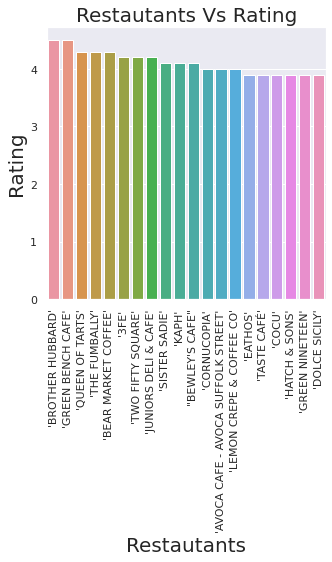

In [2]:
with open('/content/names.txt') as file:
   names = file.read().splitlines()

sent = [(',').join(names[i].lstrip('\(\)').split(',')[:-1]) for i in range(0,len(names))] 
r = [(',').join(names[i].rstrip('\(\)').split(',')[-1]) for i in range(0,len(names))]
val = [s.replace(',','') for s in r]
val = [float(i) for i in val]

plt.figure(figsize=(5,5))
sns.barplot(x=sent, y=val)
plt.title(label='Restautants Vs Rating', fontsize=20)
plt.xlabel('Restautants', fontsize=20)
plt.xticks(rotation=90)
plt.ylabel('Rating', fontsize=20)
plt.show()
